# 粒子群优化算法 Particle Swarm Optimization

xyfJASON

## 1 概述

粒子群优化算法源自鸟群的不是行为，通过个体和群体的协作和信息共享寻找最优解。特点在于实现简单，没有过多需要调节的参数。粒子群优化算法善于解决连续函数的优化问题，对于诸如 TSP 等组合优化问题需要改动为广义粒子群优化，此处不做阐述。

粒子群优化算法步骤如下：

1. 初始化一群随机粒子，每个粒子具有速度和位置两个属性 $(v_i,x_i)$
2. 每个粒子按下述公式更新速度和位置：
   $$
   \begin{cases}
   v_i=\omega\cdot v_i+c_1\cdot \text{rand()}\cdot(\text{pbest}_i-x_i)+c_2\cdot\text{rand()}\cdot(\text{gbest}-x_i)\\
   x_i=x_i+v_i
   \end{cases}
   $$
   其中，$\text{rand()}$ 是 $[0,1]$ 之间的随机数，$c_1,c_2$ 是系数，$\text{pbest}_i$ 是该粒子自身到达的最佳点，$\text{gbest}$ 是群体到达过的最佳点。
   $\omega$ 是惯性因子，可线性递减动态调节：
   $$
   \omega^{(t)}=(\omega_\text{ini}-\omega_\text{end})(G-g)/G+\omega_\text{end}
   $$
   其中，$\omega_\text{ini},\omega_\text{end}$ 分别是初始、结束惯性因子，$G$ 是最大迭代次数，$g$ 是当前迭代次数
3. 重复步骤 2 直至到达最大迭代次数

## 2 代码模板

见同文件夹下的 `modopt.py` 模块

## 3 例题

求下列函数在 $[-3,3]^2$ 上的最大值：
$$
F(x,y)=3(1-x)^2e^{-x^2-(y+1)^2}-10\left(\frac{x}{5}-x^3-y^5\right)e^{-x^2-y^2}-\frac{1}{3}^{\exp\left(-(x+1)^2-y^2\right)}
$$
代码如下：

In [1]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all'
import numpy as np

def F(x, y):
    return 3*(1-x)**2*np.exp(-(x**2)-(y+1)**2)-10*(x/5-x**3-y**5)*np.exp(-x**2-y**2)-1/3**np.exp(-(x+1)**2-y**2)

继承 `ParticleSwarmOptimization` 类，重写方法，包括：初始化粒子的速度和位置、计算粒子所在处的函数值

In [2]:
from modopt import ParticleSwarmOptimization

class Solver(ParticleSwarmOptimization):
    def gen_init_particles(self) -> tuple[np.ndarray, np.ndarray]:
        v = np.random.rand(self.n_particle, 2) * 2 - 1
        p = np.random.rand(self.n_particle, 2) * 6 - 3
        return v, p

    def evaluate_particles(self, p: np.ndarray) -> np.ndarray:
        return F(p[:, 0], p[:, 1])

设定粒子数量为 $5$，迭代次数为 $100$，粒子活动范围为 $[-3,3]^2$，运行粒子群算法：

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 6543.68it/s]


array([-0.01425461,  1.57654239])

7.150189173916368

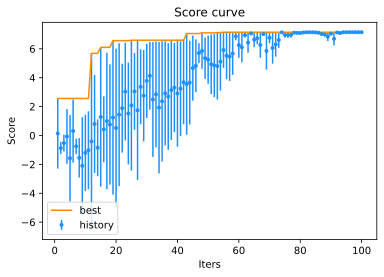

In [3]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

solver = Solver(n_particle=5,
                T=100,
                lb=np.ones((5, 2))*-3,
                ub=np.ones((5, 2))*3)
res = solver.run()

res
F(res[0], res[1])
solver.plot()